In [5]:
# Run this line in Colab to install the package if it is
# not already installed.
!/nfs/users/ext_amaya.dharmasiri/miniconda3/envs/clipglide/bin/pip install git+https://github.com/openai/glide-text2im

  Cloning https://github.com/openai/glide-text2im to /tmp/pip-req-build-p9yb7sri
  Running command git clone --filter=blob:none --quiet https://github.com/openai/glide-text2im /tmp/pip-req-build-p9yb7sri
  Resolved https://github.com/openai/glide-text2im to commit 69b530740eb6cef69442d6180579ef5ba9ef063e
  Preparing metadata (setup.py) ... done
  Using cached attrs-22.1.0-py2.py3-none-any.whl (58 kB)
  Using cached filelock-3.8.0-py3-none-any.whl (10 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 454.3 kB/s eta 0:00:000:01
  Using cached tqdm-4.64.0-py2.py3-none-any.whl (78 kB)
  Using cached ftfy-6.1.1-py3-none-any.whl (53 kB)
  Using cached regex-2022.7.25-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (765 kB)
  Using cached numpy-1.23.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.0 MB)
  Using cached urllib3-1.26.11-py2.py3-none-any.whl (139 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 682.9 kB/s eta 0:00:00a 0:00:01
  

In [10]:
%cd /nfs/users/ext_amaya.dharmasiri/repos/VL-LTR

/nfs/users/ext_amaya.dharmasiri/repos/VL-LTR


In [1]:
from PIL import Image
from IPython.display import display
import torch as th
import torch.nn as nn

from glide_text2im.clip.model_creation import create_clip_model
from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler,
)
from glide_text2im.tokenizer.simple_tokenizer import SimpleTokenizer

/nfs/users/ext_amaya.dharmasiri/miniconda3/envs/clipglide/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# This notebook supports both CPU and GPU.
# On CPU, generating one sample may take on the order of 20 minutes.
# On a GPU, it should be under a minute.

has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

In [3]:
# Create base model.
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda
options['timestep_respacing'] = '100' # use 100 diffusion steps for fast sampling
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

total base parameters 385030726


In [4]:
# Create upsampler model.
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

total upsampler parameters 398361286


In [5]:
# Create CLIP model.
clip_model = create_clip_model(device=device)
clip_model.image_encoder.load_state_dict(load_checkpoint('clip/image-enc', device))
clip_model.text_encoder.load_state_dict(load_checkpoint('clip/text-enc', device))

<All keys matched successfully>

In [6]:
def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

def show_and_save_images(batch: th.Tensor, save_path, prompt):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    final_image= Image.fromarray(reshaped.numpy())
    display(final_image)
    final_image.save(save_path+prompt+'.jpg')

In [14]:
def gen_image(prompt, batch_size, guidance_scale, upsample_temp):
    ##############################
    # Sample from the base model #
    ##############################

    # Create the text tokens to feed to the model.
    tokens = model.tokenizer.encode(prompt)
    tokens, mask = model.tokenizer.padded_tokens_and_mask(
        tokens, options['text_ctx']
    )

    # Pack the tokens together into model kwargs.
    model_kwargs = dict(
        tokens=th.tensor([tokens] * batch_size, device=device),
        mask=th.tensor([mask] * batch_size, dtype=th.bool, device=device),
    )

    # Setup guidance function for CLIP model.
    cond_fn = clip_model.cond_fn([prompt] * batch_size, guidance_scale)

    # Sample from the base model.
    model.del_cache()
    samples = diffusion.p_sample_loop(
        model,
        (batch_size, 3, options["image_size"], options["image_size"]),
        device=device,
        clip_denoised=True,
        progress=True,
        model_kwargs=model_kwargs,
        cond_fn=cond_fn,
    )
    model.del_cache()

    # Show the output
    # show_images(samples)

    ##############################
    # Upsample the 64x64 samples #
    ##############################

    tokens = model_up.tokenizer.encode(prompt)
    tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
        tokens, options_up['text_ctx']
    )

    # Create the model conditioning dict.
    model_kwargs = dict(
        # Low-res image to upsample.
        low_res=((samples+1)*127.5).round()/127.5 - 1,

        # Text tokens
        tokens=th.tensor(
            [tokens] * batch_size, device=device
        ),
        mask=th.tensor(
            [mask] * batch_size,
            dtype=th.bool,
            device=device,
        ),
    )

    # Sample from the base model.
    model_up.del_cache()
    up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
    up_samples = diffusion_up.ddim_sample_loop(
        model_up,
        up_shape,
        noise=th.randn(up_shape, device=device) * upsample_temp,
        device=device,
        clip_denoised=True,
        progress=True,
        model_kwargs=model_kwargs,
        cond_fn=None,
    )[:batch_size]
    model_up.del_cache()

    # Show the output
    # show_images(up_samples)
    save_path= '/nfs/users/ext_amaya.dharmasiri/repos/VL-LTR/notebooks/clip_gen_results/'
    show_and_save_images(up_samples, save_path, prompt)

In [11]:
# Sampling parameters
prompt = "a photo of a three toed sloth"
batch_size = 1
guidance_scale = 3.0

# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.997

a bad photo of the echidna.


100%|██████████| 27/27 [02:04<00:00,  4.60s/it]


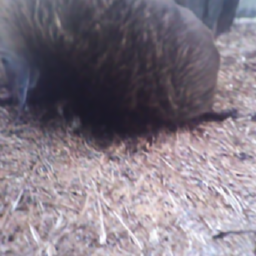

a sculpture of the echidna.


100%|██████████| 27/27 [02:02<00:00,  4.52s/it]


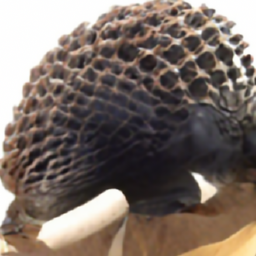

a photo of the echidna.


100%|██████████| 27/27 [02:04<00:00,  4.61s/it]


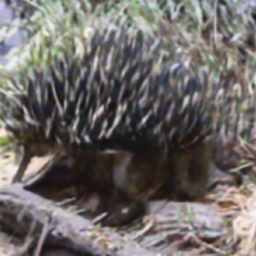

a blurry photo of a echidna.


100%|██████████| 27/27 [02:04<00:00,  4.62s/it]


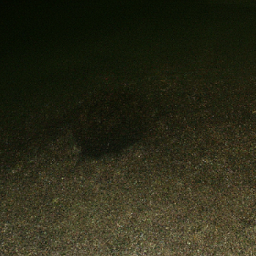

a doodle of the echidna.


100%|██████████| 27/27 [02:03<00:00,  4.57s/it]


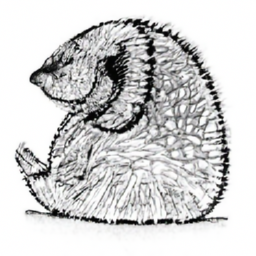

a photo of a echidna.


100%|██████████| 27/27 [02:03<00:00,  4.58s/it]


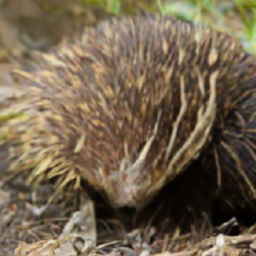

a photo of the weird combination lock.


100%|██████████| 27/27 [02:04<00:00,  4.62s/it]


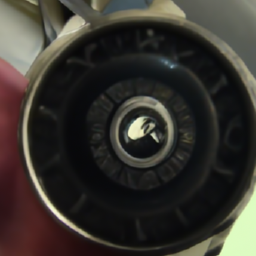

itap of the combination lock.


100%|██████████| 27/27 [02:03<00:00,  4.58s/it]


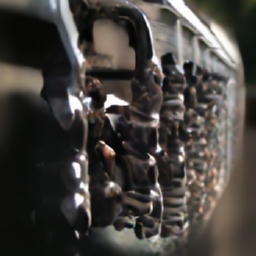

a black and white photo of the combination lock.


100%|██████████| 27/27 [02:05<00:00,  4.66s/it]


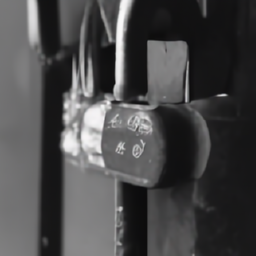

a good photo of a combination lock.


100%|██████████| 27/27 [02:05<00:00,  4.65s/it]


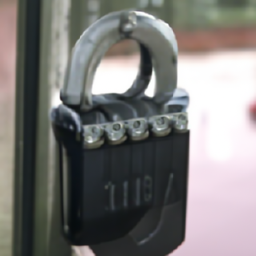

itap of the combination lock.


100%|██████████| 27/27 [02:04<00:00,  4.63s/it]


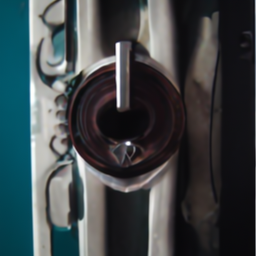

a plastic combination lock.


100%|██████████| 27/27 [02:02<00:00,  4.55s/it]


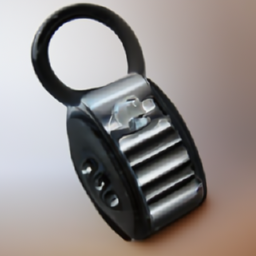

a photo of a large trench coat.


100%|██████████| 27/27 [02:03<00:00,  4.58s/it]


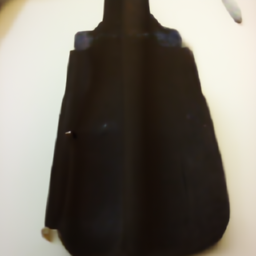

a photo of the weird trench coat.


100%|██████████| 27/27 [02:02<00:00,  4.55s/it]


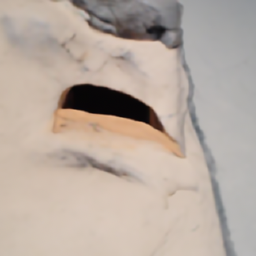

a photo of the hard to see trench coat.


100%|██████████| 27/27 [02:03<00:00,  4.56s/it]


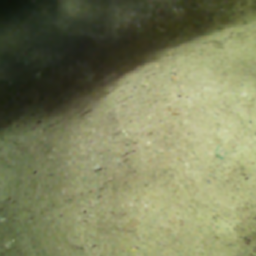

a tattoo of a trench coat.


100%|██████████| 27/27 [02:03<00:00,  4.58s/it]


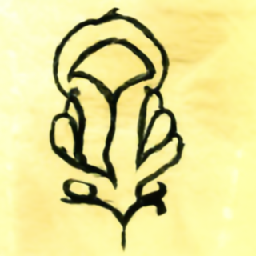

a photo of the small trench coat.


100%|██████████| 27/27 [02:03<00:00,  4.58s/it]


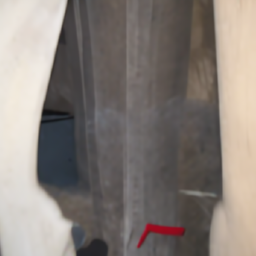

a black and white photo of a trench coat.


  4%|▎         | 1/27 [00:09<04:18,  9.93s/it]


KeyboardInterrupt: 

In [17]:
from prompt_template import prompt_templates
import random

#selecting tail classes
tail_classes=[268, 364, 102, 507, 869, 941]
#selected prompts
label_names_file= '/nfs/users/ext_amaya.dharmasiri/repos/VL-LTR/data/imagenet/labels_readable.txt'
with open(label_names_file) as f:
    label_names = f.read().splitlines()

for class_id in range(2,5):
    #get the first label name (make this random later)
    label= label_names[tail_classes[class_id]].split(':')[-1].strip().strip(',').split(',')[0].strip(' ').strip('\'')
    for i in range(6):
        #find a random prompt
        prompt= prompt_templates[random.randint(0, 70)].replace('{}', label)
        print(prompt)

        gen_image(prompt, batch_size, guidance_scale, upsample_temp)

In [64]:
prompt= prompt_templates[random.randint(0, 9)]

In [66]:
type(prompt)

str

In [24]:
type(prompt_templates)

list

In [61]:
label_names[tail_classes[1]].split(':')[-1].strip().strip(',').split(',')[0].strip(' ').strip('\'')

'three-toed sloth'